In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Copy of 01060602previewen-02d.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Alluvial_3.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Sample13.150.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/image17 (2).jpeg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Copy of image16 (3).jpeg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Alluvial_4.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Copy of image17 (2).jpeg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Copy of close-up-of-alluvial-soil-as-a-texturebackground-JCB3RY.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Alluvial_6 - Copy.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/image15 (2).jpeg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Alluvial_26.png
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/image16 (

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

In [3]:
# Preprocessing Function (CLAHE, RGB & HSV Extraction)
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(gray)
    
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:, :, 2]
    
    r, g, b = cv2.split(image)
    r = cv2.addWeighted(r, 0.7, v_channel, 0.3, 0)
    g = cv2.addWeighted(g, 0.7, v_channel, 0.3, 0)
    b = cv2.addWeighted(b, 0.7, v_channel, 0.3, 0)
    
    processed_image = cv2.merge([r, g, b])
    processed_image = cv2.resize(processed_image, (224, 224))
    
    return Image.fromarray(processed_image)

In [4]:
# Define AlexNet Model with Dropout, BatchNorm & Enhanced Features
class AlexNetModified(nn.Module):
    def __init__(self, num_classes=4):
        super(AlexNetModified, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(192),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [5]:
# Transformations for Training & Testing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# Load Dataset
data_dir = "/kaggle/input/soil-types-dataset/Dataset"
train_dataset = datasets.ImageFolder(root=f"{data_dir}/Train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
# Training the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNetModified(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [8]:
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

Epoch 1, Loss: 1.5182, Accuracy: 63.62%
Epoch 2, Loss: 2.3333, Accuracy: 65.84%
Epoch 3, Loss: 2.3917, Accuracy: 69.63%
Epoch 4, Loss: 2.0435, Accuracy: 71.52%
Epoch 5, Loss: 1.5782, Accuracy: 73.74%
Epoch 6, Loss: 0.9522, Accuracy: 79.01%
Epoch 7, Loss: 0.8918, Accuracy: 79.09%
Epoch 8, Loss: 1.3293, Accuracy: 74.90%
Epoch 9, Loss: 1.4052, Accuracy: 78.44%
Epoch 10, Loss: 1.1004, Accuracy: 78.35%
Epoch 11, Loss: 0.9482, Accuracy: 82.55%
Epoch 12, Loss: 0.5147, Accuracy: 85.35%
Epoch 13, Loss: 0.3479, Accuracy: 86.83%
Epoch 14, Loss: 0.3939, Accuracy: 87.08%
Epoch 15, Loss: 0.4143, Accuracy: 85.60%
Epoch 16, Loss: 0.3939, Accuracy: 85.27%
Epoch 17, Loss: 0.4010, Accuracy: 85.93%
Epoch 18, Loss: 0.4860, Accuracy: 83.87%
Epoch 19, Loss: 0.4248, Accuracy: 86.17%
Epoch 20, Loss: 0.3893, Accuracy: 85.19%
Epoch 21, Loss: 0.3391, Accuracy: 86.75%
Epoch 22, Loss: 0.3443, Accuracy: 88.23%
Epoch 23, Loss: 0.3278, Accuracy: 87.24%
Epoch 24, Loss: 0.3464, Accuracy: 87.16%
Epoch 25, Loss: 0.4671, A

In [9]:
# Evaluating the Model
model.eval()
correct = 0
total = 0
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"Testing Accuracy: {test_accuracy:.2f}%")


Testing Accuracy: 90.29%



Classification Report:
               precision    recall  f1-score   support

Alluvial soil       0.70      0.79      0.74        53
   Black Soil       0.97      0.90      0.93       116
    Clay soil       0.83      0.85      0.84        65
     Red soil       0.99      1.00      1.00       106

     accuracy                           0.90       340
    macro avg       0.87      0.88      0.88       340
 weighted avg       0.91      0.90      0.90       340



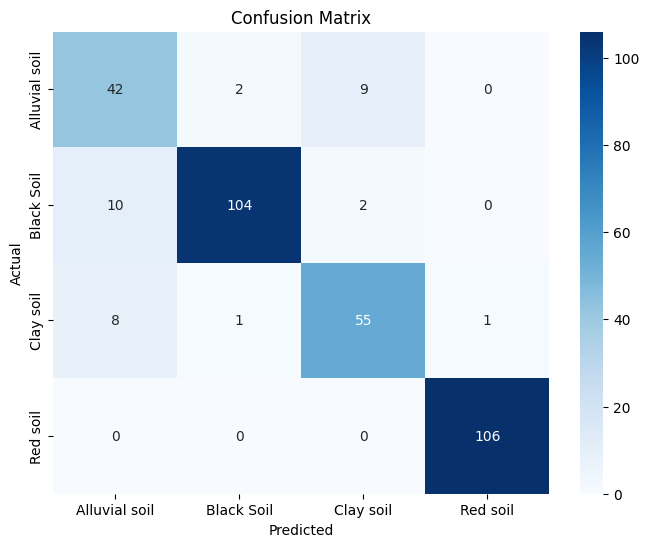

In [10]:
# Confusion Matrix & Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()